# Implementation Convolutional Bayesian Denoising Autoencoder Alzheimer MRI Scan Dataset


## Data loading and processing

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
def plot_mnist_images(mnist_dataset):
    # Prepare to plot 2 rows of 5 images
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()

    # Plot MNIST images
    for i in range(10):  # First 2 rows (MNIST)
        image, label = mnist_dataset[i]
        image = image.squeeze().numpy()  # Convert tensor to numpy array and remove single-dimensional entries
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust vertical and horizontal space
    plt.tight_layout()
    plt.show()

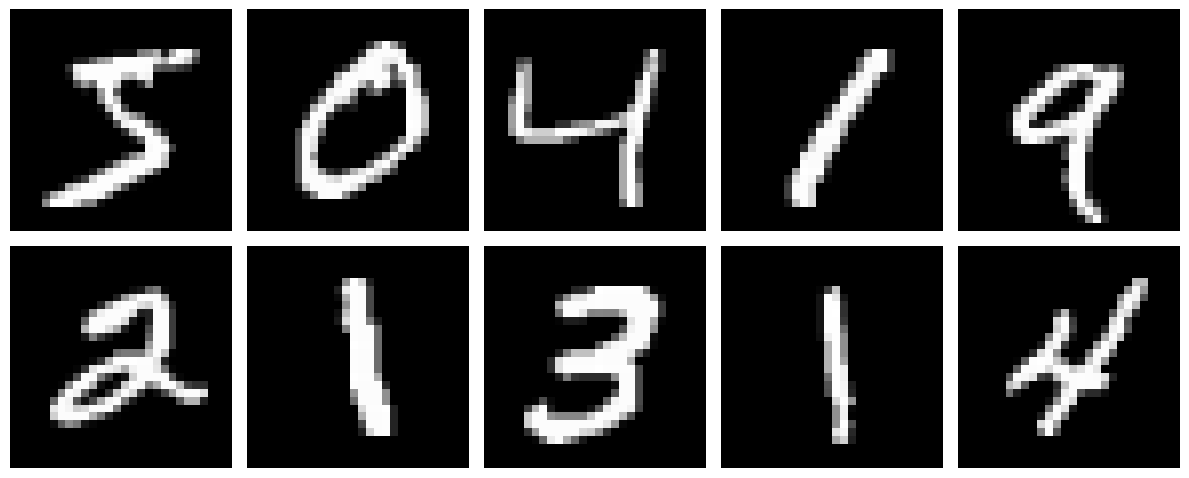

In [17]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

mnist_dataset = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)

# Call the function with the datasets
plot_mnist_images(mnist_dataset)

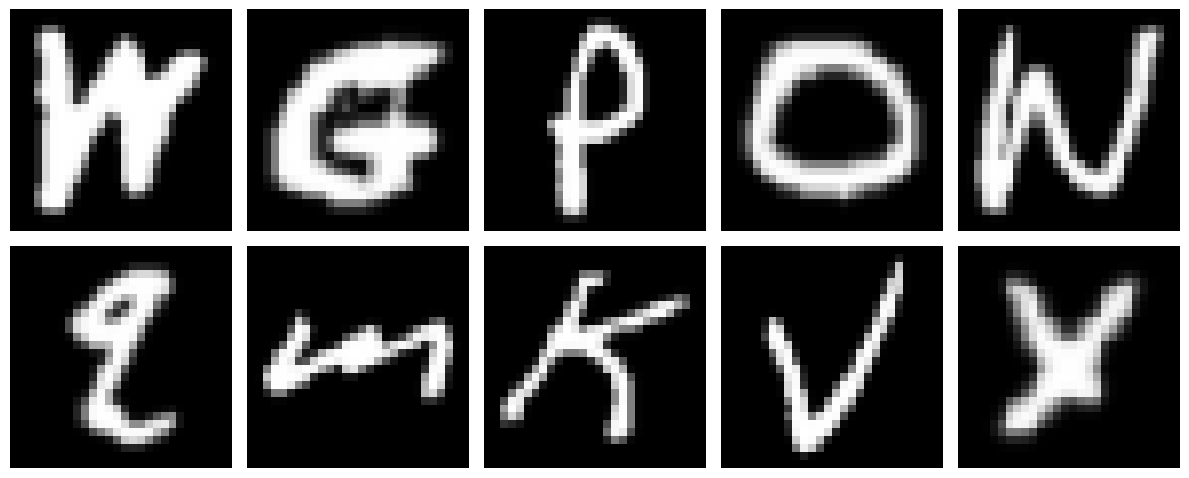

In [18]:
# Load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
    root='./data',
    download=True,
    split='letters',
    train=True,
    transform=transforms.Compose([
        lambda img: transforms.functional.rotate(img, -90),
        lambda img: transforms.functional.hflip(img),
        transforms.ToTensor()
    ])
)

plot_mnist_images(emnist_dataset)

In [ ]:
# Constants
image_size = 128
dataset_path = '/content/drive/MyDrive/mri_dataset'
batch_size = 64

# Custom Dataset Class
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.jpeg', '.jpg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L').resize((image_size, image_size))
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label

# Create dataset instance
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

In [21]:
def plot_dataset(dataset, num_images=18):
    # Prepare to plot 2 rows of 9 images
    fig, axes = plt.subplots(2, 9, figsize=(17, 4))  # Adjust the figsize as needed
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:  # Ensure we don't go out of the dataset bounds
            image, _ = dataset[i]
            ax.imshow(image.squeeze(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Turn off axes for any extra subplots
    plt.tight_layout()
    plt.show()

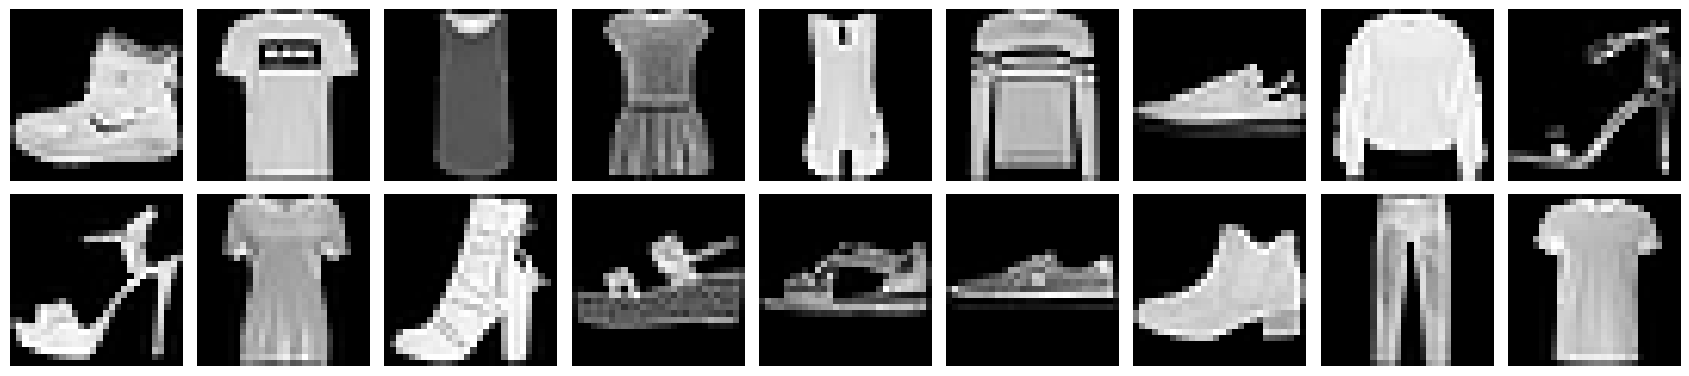

In [22]:
# load the training and test datasets
fashion_dataset = datasets.FashionMNIST(root='data', train=True,
                                      download=True, transform=transform)

plot_dataset(fashion_dataset)

In [25]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

image_size = 128

class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpeg') or fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        image.draft('L', (image_size, image_size))

        if self.transform:
            image = self.transform(image)

        # If you have labels, modify this part to return the corresponding label as well.
        return (image, 0)

# Define the path to your dataset
dataset_path = '/content/drive/MyDrive/mri_dataset'

# Define any transformations (e.g., normalization, resizing)
transform = transforms.Compose([
    # transforms.Resize((image_size, image_size)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Create an instance of the dataset
xray_dataset = MRIDataset(root_dir=dataset_path, transform=transform)

print(len(xray_dataset))

# Split dataset into train/validation/test sets
train_indices, temp_indices = train_test_split(np.arange(len(xray_dataset)), test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Create data loaders
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = DataLoader(xray_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(xray_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(xray_dataset, batch_size=64, sampler=test_sampler)

# Checking dataset sizes
print(f'Training dataset size: {len(train_sampler)}')
print(f'Validation dataset size: {len(val_sampler)}')
print(f'Test dataset size: {len(test_sampler)}')

print(len(train_loader))

6400
Training dataset size: 4480
Validation dataset size: 960
Test dataset size: 960
70


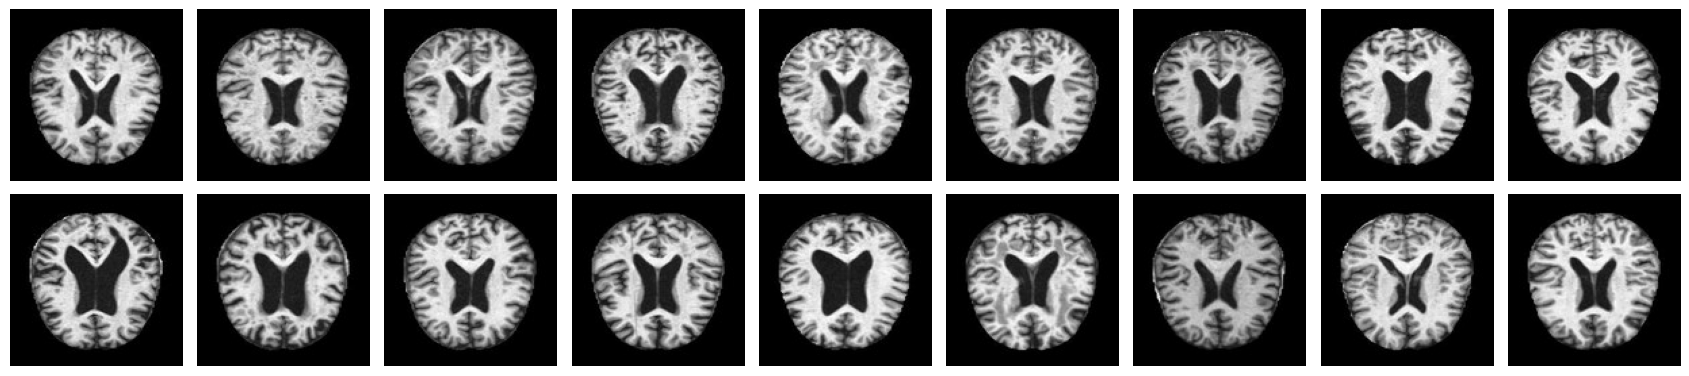

In [26]:
plot_dataset(xray_dataset)

In [27]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

In [28]:
def get_image_row(dataset, start_index, num_images=3):
    images = []
    for i in range(num_images):
        image, _ = dataset[start_index + i]
        images.append(image)
    return images

# Assuming you want to plot the first row of images
start_index_mnist = 0
start_index_fashion = 0
start_index_xray = 0

mnist_images = get_image_row(mnist_dataset, start_index_mnist)
fashion_images = get_image_row(fashion_dataset, start_index_fashion)
xray_images = get_image_row(xray_dataset, start_index_xray)

In [54]:
def plot_row(mnist_images, fashion_images, xray_images, noise_factor):
    plt.figure(figsize=(17, 4))

    # Plot MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 1)
        noisy_image = add_gaussian_noise(mnist_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('MNIST')
        plt.axis('off')

    # Plot Fashion MNIST images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 4)
        noisy_image = add_gaussian_noise(fashion_images[i].view(1, 28, 28), noise_factor)
        plt.imshow(noisy_image.view(28, 28), cmap='gray')
        # plt.title('Fashion MNIST')
        plt.axis('off')

    # Plot X-ray images with added Gaussian noise
    for i in range(3):
        plt.subplot(1, 9, i + 7)
        noisy_image = add_gaussian_noise(xray_images[i].view(1, 128, 128), noise_factor)
        plt.imshow(noisy_image.view(128, 128), cmap='gray')
        # plt.title('X-ray')
        plt.axis('off')

    # Add caption with noise_factor value
    # plt.figtext(0.5, 0.32, f"σ = {noise_factor}", ha='center', fontsize=12)

    # plt.tight_layout(pad=0.1)  # Adjust padding between plot and figure edges
    plt.show()

plot_row(mnist_images, fashion_images, xray_images, 0)

In [59]:
def plot_row(mnist_images, fashion_images, xray_images, noise_factor):
    plt.figure(figsize=(17, 4))  # Set the figure size to match the desired layout

    total_columns = 9  # Total number of columns

    # Function to plot a single image with Gaussian noise
    def plot_image_with_noise(image, index, total_columns, image_size):
        noisy_image = add_gaussian_noise(image.view(1, *image_size), noise_factor)
        ax = plt.subplot(2, total_columns, index + 1)  # Adjusted to handle two rows
        ax.imshow(noisy_image.view(*image_size), cmap='gray')
        ax.axis('off')

    # Plot first row
    for i in range(3):
        plot_image_with_noise(mnist_images[i], i, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(fashion_images[i], i + 3, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(xray_images[i], i + 6, total_columns, (128, 128))

    # Plot second row (same images)
    for i in range(3):
        plot_image_with_noise(mnist_images[i], i + 9, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(fashion_images[i], i + 12, total_columns, (28, 28))

    for i in range(3):
        plot_image_with_noise(xray_images[i], i + 15, total_columns, (128, 128))

    plt.tight_layout(pad=1)  # Adjust the padding between plots
    plt.show()

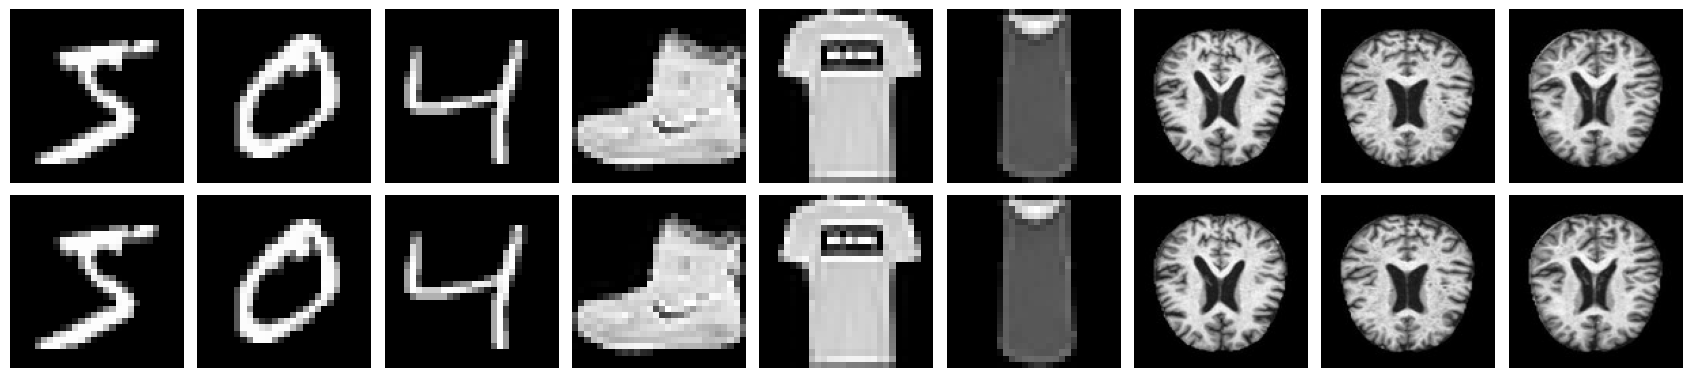

In [60]:
plot_row(mnist_images, fashion_images, xray_images, 0)

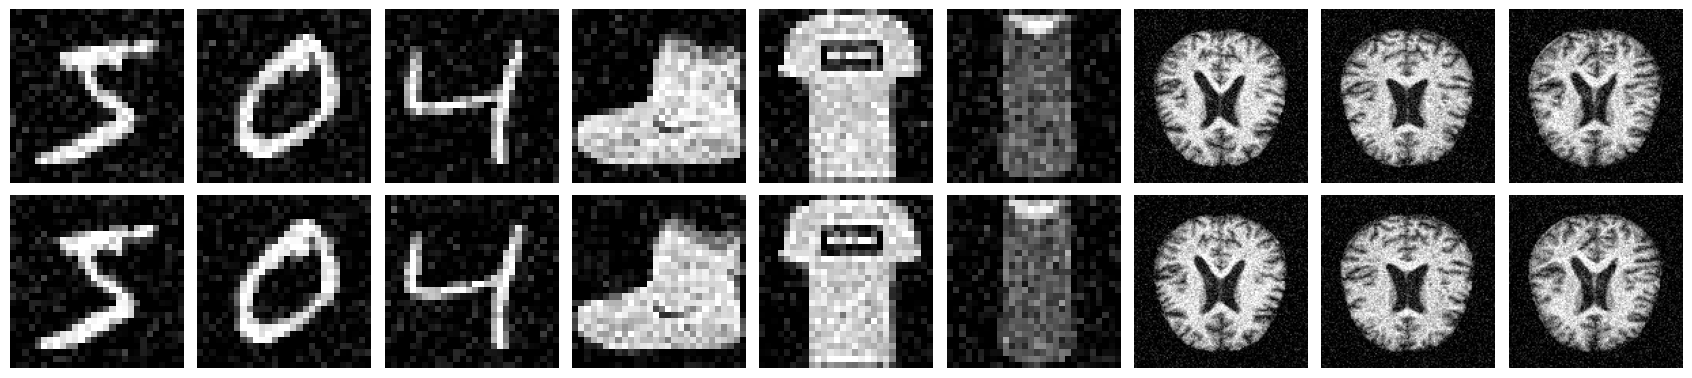

In [61]:

plot_row(mnist_images, fashion_images, xray_images, 0.1)

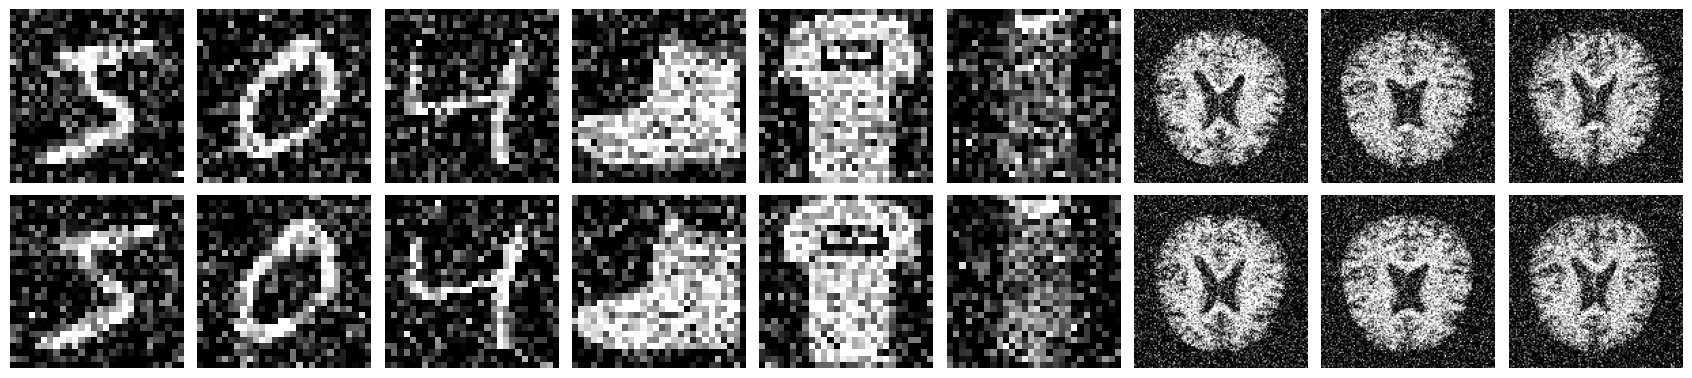

In [62]:
plot_row(mnist_images, fashion_images, xray_images, 0.3)

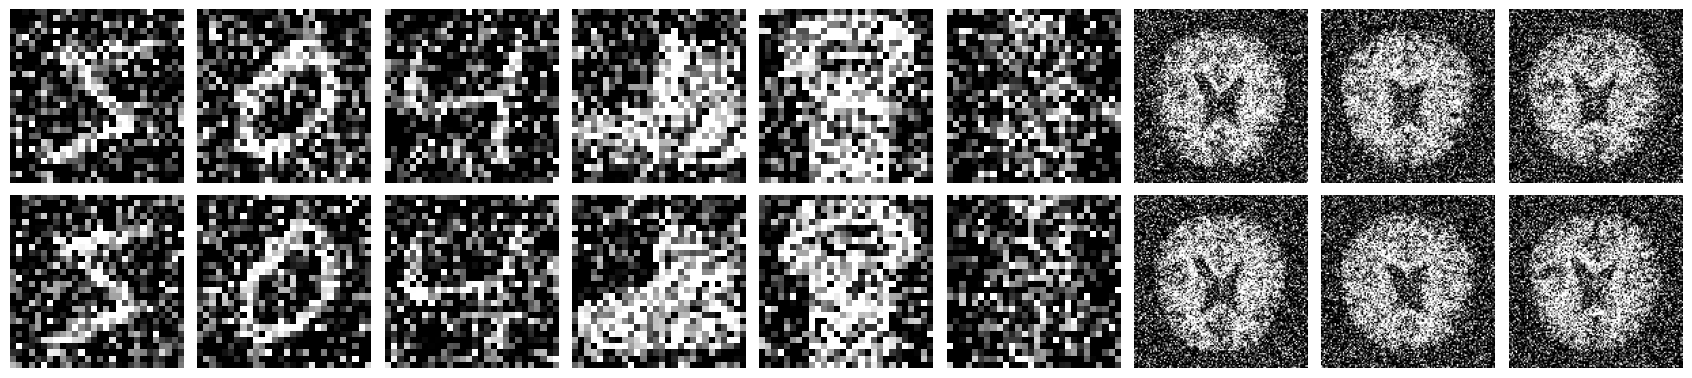

In [63]:
plot_row(mnist_images, fashion_images, xray_images, 0.5)

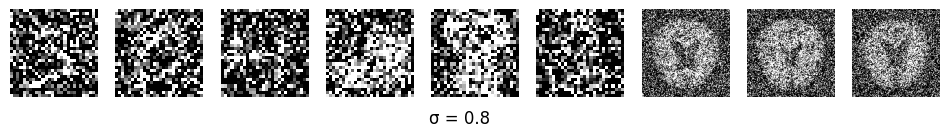

In [ ]:
plot_row(mnist_images, fashion_images, xray_images, 0.8)